In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization
import visualkeras

In [3]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] +self.w3 * inputs[2]

In [4]:
labels_csv = pd.read_csv('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\\Codes\\Dog-Breed-Classification-using-Ensemble-Pretrained-Models-main\\labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]
data_train = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-224\\train')
data_test = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-224\\train')

In [5]:
batch_size = 16
img_size = 224

In [6]:
datagen = ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input, validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

validation_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train,
                        subset="validation",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [7]:
vgg16 = applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))
inceptionV3 = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in vgg16 .layers:
    layer.trainable=False
for layer in resnet50.layers:
    layer.trainable=False
for layer in inceptionV3.layers:
    layer.trainable=False

model1 = Sequential()
model2 = Sequential()
model3 = Sequential()

model1.add(vgg16)
model1.add(BatchNormalization())
model1.add(GlobalAveragePooling2D())
model1.add(Dropout(0.5))
model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(120, activation='softmax'))

model2.add(resnet50)
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(120, activation='softmax'))

model3.add(inceptionV3)
model3.add(BatchNormalization())
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.5))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(120, activation='softmax'))

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model2.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model3.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
# model1.save('model1.h5')
# model2.save('model2.h5')
# model3.save('model3.h5')

# history_vgg = model1.fit(train_generator, epochs=20, verbose = 1,
#                          validation_data=validation_generator)
#
# history_res = model2.fit(train_generator, epochs=20, verbose = 1,
#                        validation_data=validation_generator)
#
# history_inc = model3.fit(train_generator, epochs=20, verbose = 1,
#                         validation_data=validation_generator)


In [8]:
models = [model1,model2,model3]
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 120)          15535288    ['input_4[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 120)          25817080    ['input_4[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 120)          24032152    ['input_4[0][0]']            

In [9]:
history_ens = ensemble_model.fit(train_generator, epochs=20, verbose = 1,
                                 validation_data=validation_generator)

Epoch 1/20
512/512 [==============================] - 1350s 3s/step - loss: 4.3424 - accuracy: 0.1174 - val_loss: 3.3645 - val_accuracy: 0.4457
Epoch 2/20
512/512 [==============================] - 1343s 3s/step - loss: 3.0693 - accuracy: 0.4261 - val_loss: 2.4333 - val_accuracy: 0.5915
Epoch 3/20
512/512 [==============================] - 1350s 3s/step - loss: 2.4141 - accuracy: 0.5644 - val_loss: 2.0749 - val_accuracy: 0.6786
Epoch 4/20
512/512 [==============================] - 1348s 3s/step - loss: 2.1064 - accuracy: 0.6186 - val_loss: 1.9102 - val_accuracy: 0.7001
Epoch 5/20
512/512 [==============================] - 1341s 3s/step - loss: 1.9369 - accuracy: 0.6566 - val_loss: 1.8167 - val_accuracy: 0.7060
Epoch 6/20
512/512 [==============================] - 1336s 3s/step - loss: 1.8057 - accuracy: 0.6749 - val_loss: 1.7505 - val_accuracy: 0.7035
Epoch 7/20
512/512 [==============================] - 1337s 3s/step - loss: 1.7138 - accuracy: 0.6921 - val_loss: 1.7017 - val_accuracy:

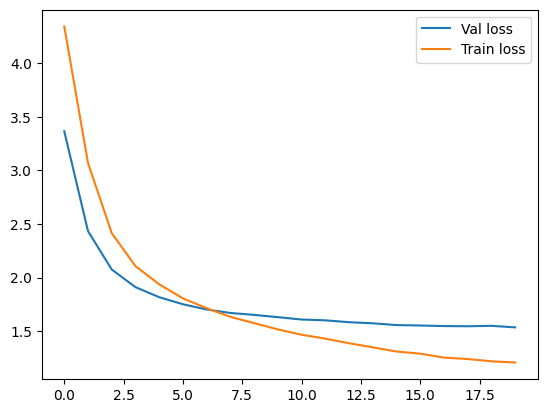

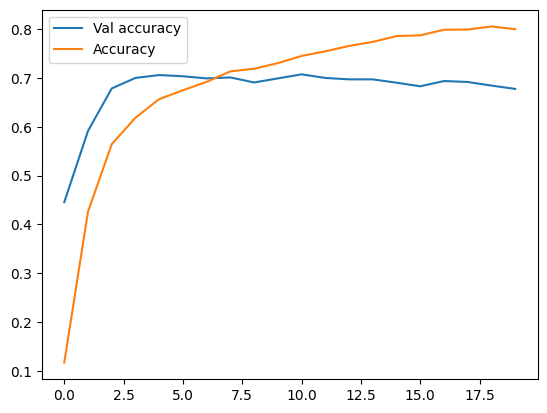

In [10]:
plt.figure()
plt.plot(history_ens .history["val_loss"], label = "Val loss")
plt.plot(history_ens .history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ens .history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ens .history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

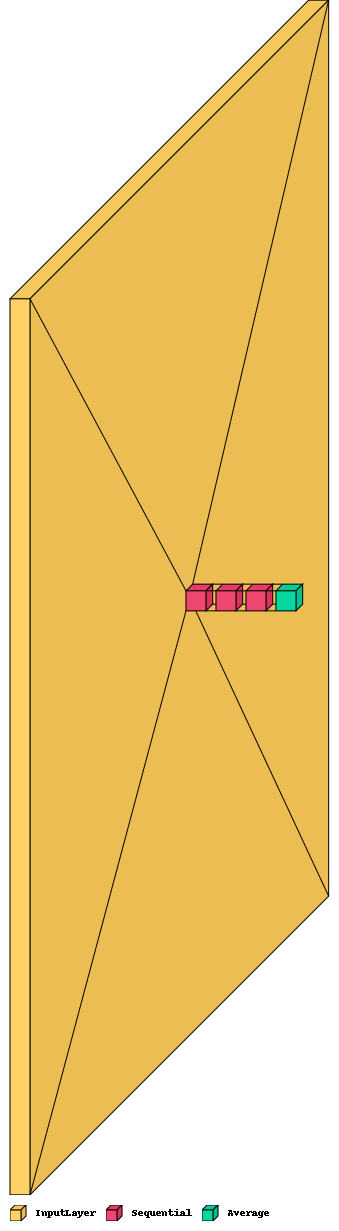

In [11]:
visualkeras.layered_view(ensemble_model,  legend=True)